In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from numpy import linalg as LA
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline

# Functions to read data

In [2]:
def read_US_states(fname):
    states_abb_dict = {}
    states_abb_rev_dict = {}
    states_abb_ord_list = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip().split(",")
            name = line[0]
            abbr = line[1]
            states_abb_dict[name] = (abbr, len(states_abb_ord_list))
            states_abb_rev_dict[abbr] = name
            states_abb_ord_list.append(abbr)
    
    return states_abb_dict, states_abb_rev_dict, states_abb_ord_list

def read_travel_network(fname, states_abb_dict, states_abb_rev_dict, normalization=1):
    num_states = 50

    adjacency_list = {}
    A = np.zeros((num_states, num_states))

    for abb in states_abb_rev_dict:
        adjacency_list[abb] = []

    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            orig = line[0]
            dest = line[1]
            weight = float(line[2])*10 / normalization
            if orig == dest:
                continue
            try:
                orig_abb, orig_idx = states_abb_dict[orig]
                dest_abb, dest_idx = states_abb_dict[dest]
                adjacency_list[orig_abb].append((dest_abb, weight))
                A[orig_idx][dest_idx] = weight
            except KeyError:
                pass
    
    return adjacency_list, A

def read_deaths_data(fname):
    df = pd.read_csv(fname)
    sum_df_d = df.groupby(['State', 'Year', 'Quarter', 'Month'])[['DeathsFromPneumoniaAndInfluenza']].sum().T.to_dict()
    deaths_dict = {}
    for key, deaths in sum_df_d.items():
        state, year, quarter, month = key
        if state == "DC":
            continue
        if state not in deaths_dict:
            deaths_dict[state] = {}
        if year not in deaths_dict[state]:
            deaths_dict[state][year] = {}
        if quarter not in deaths_dict[state][year]:
            deaths_dict[state][year][quarter] = {}
        deaths_dict[state][year][quarter][month] = deaths["DeathsFromPneumoniaAndInfluenza"]
    return deaths_dict

def read_population_dict(fname):
    population_dict = {}
    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            state = line[1]
            population_dict[state] = {}
            year = 2009
            for idx, pop in enumerate(line[2:]):
                population_dict[state][year + idx] = int(pop)
    return population_dict

In [3]:
class State:
    def __init__(self, pop):
        self.num_total = pop
        self.num_infected = 0
        self.num_deceased = 0
    
    def infected_fraction(self):
        return self.num_infected / self.num_total

# Function to run simulation

In [4]:
def travel_and_infect_kernel(A, states, p_transfer, verbose=False):
    N = A.shape[0]
    new_states = copy(states)
    
    infected_fraction = np.zeros((N,))
    for i in range(N):
        infected_fraction[i] = states[i].infected_fraction()
    
    touch_fraction = 1
    
    for dest_id in range(N):
        
        # Let X be number of successful infections.
        # X is Binomial(n, p_transfer) where n is number of travelers.
        # We want X >= 1 for each person at destination i.e.,
        # at least one successful infection for each person at destination.
        # So, calculate p' = P(X >= 1) = 1 - P(X = 0) = 1 - (1-p_transfer)^n.
        # p' is the probability a person at destination gets infected.
        # This reduces problem to calculate a new r.v. Y.
        # Y is Binomial(m, p'), where m is the uninfected population of destination
        
        num_immigrants = A[:, i]
        num_infected_immigrants = np.matmul(num_immigrants, infected_fraction.T)
        # in expectation:
        # num_infected_immigrants = np.sum(A[:, i]) * p_inf
        ccdf = 1 - (1 - p_transfer)**num_infected_immigrants
        dest = states[dest_id]
        if dest.num_total - dest.num_infected > 0:
            if np.isnan(ccdf):
                ccdf = 1
            new_states[dest_id].num_infected += np.random.binomial(
                touch_fraction*(dest.num_total - dest.num_infected), ccdf)
#             # in expectation:
#             new_states[dest_id].num_infected += (dest.num_total - dest.num_infected) * ccdf
        
    return new_states

def recover_kernel(states, SIR_params):
    SIR_params = np.abs(SIR_params) / np.sum(np.abs(SIR_params))
    for i, state in enumerate(states):
        x = np.random.multinomial(states[i].num_infected, SIR_params)
        recovered = x[0]
        dead = x[2]
        state.num_total = max(state.num_total - dead, 0)
        states[i].num_infected -= (dead + recovered)
        states[i].num_deceased += dead
    return states

def local_infection_kernel(states, p_transfer):
    touch_fraction = 1
    for i, state in enumerate(states):
        states[i].num_infected = np.random.binomial(touch_fraction*(state.num_total - state.num_infected), p_transfer)
    return states

def remove_deceased_kernel(states):
    num_deceased = []
    for i, state in enumerate(states):
        num_deceased.append(state.num_deceased)
        state.num_deceased = 0
        states[i] = state
    return states, num_deceased
    
def inject_population_kernel(states, new_population):
    # new_population is somehow ordered
    for i, state in enumerate(states):
        current_pop = state.num_total
        nextgen_pop = new_population[i]
        extra_peeps = nextgen_pop - current_pop
        if extra_peeps > 0:
            state.num_total += extra_peeps
        elif extra_peeps < 0:
            # population actually decreased... remove infected and susceptible at same rate
            extra_peeps = -extra_peeps
            if extra_peeps // 2 >= state.num_infected:
                state.num_total = state.num_total - (extra_peeps - state.num_infected)
                state.num_infected = 0
            else:
                state.num_infected -= (extra_peeps - extra_peeps//2)
                state.num_total -= extra_peeps
        states[i] = state
    return states

def random_infection_kernel(states, p_inf):
    for i, state in enumerate(states):
        if state.num_total < state.num_infected:
            continue
        infected = np.random.binomial(state.num_total - state.num_infected, p_inf)
        state.num_infected += infected
        states[i] = state
    return states

# Get real data

In [5]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)

quarter_to_month = {1:[1,2,3],
                    2:[4,5,6],
                    3:[7,8,9],
                    4:[10,11,12]
                   }

adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = {}#read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]
for i in range(10,13):
    A[2009][4][i] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]

for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        A[year][quarter] = {}
        for month in quarter_to_month[quarter]:
            network_fname = str(year) + "_Q" + str(quarter) + ".csv"
            A[year][quarter][month] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = {}#read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]
for i in range(1,4):
    A[2019][1][i] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
#         print(year, pop)
        all_population[year].append(pop)
        if year == 2018:
            all_population[2019].append(pop)
        
A_dict = A

deaths_matrix = {-1: [], 1: [], 2: [], 3: [],
                 4: [], 5: [], 6: [], 7: [],
                 8: [], 9: [], 10: [], 11: [], 12: []
                }

for state, yearly_deaths_dict in deaths_dict.items():
    deaths_vector = {}
    for q in deaths_matrix:
        deaths_vector[q] = []
    for year, quarterly_deaths_dict in yearly_deaths_dict.items():
        for quarter, monthly_deaths_dict in quarterly_deaths_dict.items():
            for month, deaths_count in monthly_deaths_dict.items():
#                 print(year, quarter, month)
                deaths_vector[-1].append(deaths_count)
                deaths_vector[month].append(deaths_count)
    for q in deaths_matrix:
        deaths_matrix[q].append(deaths_vector[q])
for q in deaths_matrix:
    deaths_matrix[q] = np.array(deaths_matrix[q])
    print(deaths_matrix[q].shape)

(50, 119)
(50, 11)
(50, 10)
(50, 11)
(50, 9)
(50, 9)
(50, 10)
(50, 9)
(50, 9)
(50, 11)
(50, 10)
(50, 10)
(50, 10)


# Run monthly simulation


In [52]:
def run_full_simulation(x, A_dict, all_population, error=False, sim_month=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
            num_deceased[year][quarter] = {}
            for month in quarter_to_month[quarter]:
                if sim_month != -1 and month != sim_month:
                    continue
#                 print(year, quarter, month)
                # 1. travel and infect
                # 2. Recover
                # 3. Remove deceased and store it
                # 4. Randomly infect

                # add sinusoidal element to probability of infection
                p_i = p_inf*(0.25*np.cos((np.pi/6)*month)+0.75)
                p_t = p_transfer*(0.25*np.cos((np.pi/6)*month)+0.75)

                states = travel_and_infect_kernel(A_dict[year][quarter][month], states, p_t)
                states = recover_kernel(states, SIR)

                for i in range(2):
                    states = local_infection_kernel(states, p_t)
                    states = recover_kernel(states, SIR)

                states, dead_peeps = remove_deceased_kernel(states)
                num_deceased[year][quarter][month] = dead_peeps
                states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    count = 0
    sim_deaths_matrix = []
    for year, quarterly_deaths in num_deceased.items():
#         print("quarterly: " + str(len(quarterly_deaths)))
        for quarter, monthly_deaths in quarterly_deaths.items():
#             print("monthly: " + str(len(monthly_deaths)))
            count += len(monthly_deaths)
            for month, deaths_vector in monthly_deaths.items():
#                 print(year,quarter,month)
                sim_deaths_matrix.append(deaths_vector)
    

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
#         print(deaths_matrix[sim_month][:,:-5].shape, sim_deaths_matrix.shape)
        return LA.norm(deaths_matrix[sim_month][:,:-5] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_month], ord='fro')
    else:
        return sim_deaths_matrix
    
    
def run_full_simulation_no_travel(x, A_dict, all_population, error=False, sim_month=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
            num_deceased[year][quarter] = {}
            for month in quarter_to_month[quarter]:
                if sim_month != -1 and month != sim_month:
                    continue
#                 print(year, quarter, month)
                # 1. travel and infect
                # 2. Recover
                # 3. Remove deceased and store it
                # 4. Randomly infect

                # add sinusoidal element to probability of infection
                p_i = p_inf*(0.25*np.cos((np.pi/6)*month)+0.75)
                p_t = p_transfer*(0.25*np.cos((np.pi/6)*month)+0.75)

#                 states = travel_and_infect_kernel(A_dict[year][quarter][month], states, p_t)
                states = recover_kernel(states, SIR)

                for i in range(2):
                    states = local_infection_kernel(states, p_t)
                    states = recover_kernel(states, SIR)

                states, dead_peeps = remove_deceased_kernel(states)
                num_deceased[year][quarter][month] = dead_peeps
                states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    count = 0
    sim_deaths_matrix = []
    for year, quarterly_deaths in num_deceased.items():
#         print("quarterly: " + str(len(quarterly_deaths)))
        for quarter, monthly_deaths in quarterly_deaths.items():
#             print("monthly: " + str(len(monthly_deaths)))
            count += len(monthly_deaths)
            for month, deaths_vector in monthly_deaths.items():
#                 print(year,quarter,month)
                sim_deaths_matrix.append(deaths_vector)
    

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
#         print(deaths_matrix[sim_month][:,:-5].shape, sim_deaths_matrix.shape)
        return LA.norm(deaths_matrix[sim_month][:,:-5] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_month], ord='fro')
    else:
        return sim_deaths_matrix
    
    
    
    
def run_full_simulation_no_seasonality(x, A_dict, all_population, error=False, sim_month=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
            num_deceased[year][quarter] = {}
            for month in quarter_to_month[quarter]:
                if sim_month != -1 and month != sim_month:
                    continue
#                 print(year, quarter, month)
                # 1. travel and infect
                # 2. Recover
                # 3. Remove deceased and store it
                # 4. Randomly infect

                # add sinusoidal element to probability of infection
                p_i = p_inf#*(0.25*np.cos((np.pi/6)*month)+0.75)
                p_t = p_transfer#*(0.25*np.cos((np.pi/6)*month)+0.75)

                states = travel_and_infect_kernel(A_dict[year][quarter][month], states, p_t)
                states = recover_kernel(states, SIR)

                for i in range(2):
                    states = local_infection_kernel(states, p_t)
                    states = recover_kernel(states, SIR)

                states, dead_peeps = remove_deceased_kernel(states)
                num_deceased[year][quarter][month] = dead_peeps
                states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    count = 0
    sim_deaths_matrix = []
    for year, quarterly_deaths in num_deceased.items():
#         print("quarterly: " + str(len(quarterly_deaths)))
        for quarter, monthly_deaths in quarterly_deaths.items():
#             print("monthly: " + str(len(monthly_deaths)))
            count += len(monthly_deaths)
            for month, deaths_vector in monthly_deaths.items():
#                 print(year,quarter,month)
                sim_deaths_matrix.append(deaths_vector)
    

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
#         print(deaths_matrix[sim_month][:,:-5].shape, sim_deaths_matrix.shape)
        return LA.norm(deaths_matrix[sim_month][:,:-5] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_month], ord='fro')
    else:
        return sim_deaths_matrix
    
    
    
def run_full_simulation_neither(x, A_dict, all_population, error=False, sim_month=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
            num_deceased[year][quarter] = {}
            for month in quarter_to_month[quarter]:
                if sim_month != -1 and month != sim_month:
                    continue
#                 print(year, quarter, month)
                # 1. travel and infect
                # 2. Recover
                # 3. Remove deceased and store it
                # 4. Randomly infect

                # add sinusoidal element to probability of infection
                p_i = p_inf#*(0.25*np.cos((np.pi/6)*month)+0.75)
                p_t = p_transfer#*(0.25*np.cos((np.pi/6)*month)+0.75)

#                 states = travel_and_infect_kernel(A_dict[year][quarter][month], states, p_t)
                states = recover_kernel(states, SIR)

                for i in range(2):
                    states = local_infection_kernel(states, p_t)
                    states = recover_kernel(states, SIR)

                states, dead_peeps = remove_deceased_kernel(states)
                num_deceased[year][quarter][month] = dead_peeps
                states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    count = 0
    sim_deaths_matrix = []
    for year, quarterly_deaths in num_deceased.items():
#         print("quarterly: " + str(len(quarterly_deaths)))
        for quarter, monthly_deaths in quarterly_deaths.items():
#             print("monthly: " + str(len(monthly_deaths)))
            count += len(monthly_deaths)
            for month, deaths_vector in monthly_deaths.items():
#                 print(year,quarter,month)
                sim_deaths_matrix.append(deaths_vector)
    

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
#         print(deaths_matrix[sim_month][:,:-5].shape, sim_deaths_matrix.shape)
        return LA.norm(deaths_matrix[sim_month][:,:-5] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_month], ord='fro')
    else:
        return sim_deaths_matrix

# Find best params: seasonality + air travel

In [48]:
def perturbe(x, mu=0, sigma=1e-4):
    return x + np.random.normal(mu, sigma, size=x.shape)

def isvalid(x):
    return (x <= 1).all() and (x >= 0).all()

error_tol = 0.5
month = -1
x_best = np.array([0.1, 0.1, 0.99])

print(x_best)
error = run_full_simulation(x_best, A_dict, all_population, True, sim_month=month)
print("0", error)
error_best = error

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best, mu=0, sigma=1e-1)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = run_full_simulation(x_i, A_dict, all_population, True, sim_month=month)
    ctr += 1
    if error < error_best:
        x_best = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 1.1513470214676986
1 1.1407842277594304
2 0.9962537690731229
6 0.9826554192315519
Invalid:  10
Counter:  10
Invalid:  20
Counter:  20
Invalid:  30
29 0.9039839505423004
Counter:  30
Invalid:  40
Counter:  40
Invalid:  50
Invalid:  60
Counter:  50
Invalid:  70
Counter:  60
Invalid:  80
Invalid:  90
Counter:  70
Invalid:  100
Counter:  80
Invalid:  110
Invalid:  120
Counter:  90
Invalid:  130
Counter:  100
Counter:  110
Invalid:  140
Invalid:  150
Counter:  120
Counter:  130
Invalid:  160
Counter:  140
Invalid:  170
Counter:  150
Invalid:  180
Invalid:  190
Counter:  160
Invalid:  200
Counter:  170
Invalid:  210
Counter:  180
Invalid:  220
Counter:  190
Counter:  200
Invalid:  230
Counter:  210
Invalid:  240
Invalid:  250
Counter:  220
Invalid:  260
Counter:  230
Invalid:  270
Invalid:  280
Counter:  240
Invalid:  290
Counter:  250


KeyboardInterrupt: 

# Find best params: seasonality + no air travel

In [49]:
x_best_no_travel = np.array([0.1, 0.1, 0.99])

print(x_best_no_travel)
error = run_full_simulation_no_travel(x_best_no_travel, A_dict, all_population, True, sim_month=month)
print("0", error)
error_best = error

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best_no_travel, mu=0, sigma=1e-1)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = run_full_simulation_no_travel(x_i, A_dict, all_population, True, sim_month=month)
    ctr += 1
    if error < error_best:
        x_best_no_travel = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.7461254713099638
1 0.6496360049222392
2 0.6393605210507713
Counter:  10
11 0.6389585443223809
14 0.6375910264044504
Counter:  20
Invalid:  10
30 0.637348417637419
39 0.6369162485373132
Counter:  40
43 0.6359313428893832
Invalid:  20
Counter:  50
57 0.6357903553109087
59 0.6352493579729653
Counter:  60
Counter:  70
71 0.6343619247257171
Counter:  80
Counter:  90
Invalid:  30
99 0.6338718121928968
100 0.63356980426839
Counter:  110
118 0.6329529505592928
Counter:  120
Counter:  130
Counter:  140
Counter:  150
Counter:  160
Counter:  170
Invalid:  40
179 0.6322850632293571
Counter:  180
Counter:  190
Counter:  200
Counter:  210
Counter:  220
Invalid:  50
Counter:  230
Counter:  240
Counter:  250
Counter:  260
Counter:  270
Invalid:  60
Counter:  280
Counter:  290
Counter:  300


KeyboardInterrupt: 

# Find best params: no seasonality + air travel

In [50]:
x_best_no_seasonality = np.array([0.1, 0.1, 0.99])

print(x_best_no_seasonality)
error = run_full_simulation_no_seasonality(x_best_no_seasonality, A_dict, all_population, True, sim_month=month)
print("0", error)
error_best = error

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best_no_seasonality, mu=0, sigma=1e-1)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = run_full_simulation_no_seasonality(x_i, A_dict, all_population, True, sim_month=month)
    ctr += 1
    if error < error_best:
        x_best_no_seasonality = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 1.2087505870097963
1 1.1857089470875428
4 1.1300612607393048
5 1.1158002702142547
10 1.0805393581403946
13 0.991862424478907
Invalid:  10
Counter:  20
Invalid:  20
Counter:  30
33 0.9730974079699515
Invalid:  30
39 0.9587747212508139
Counter:  40
Invalid:  40
Invalid:  50
Counter:  50
Invalid:  60
Counter:  60
Invalid:  70
Counter:  70
Invalid:  80
Invalid:  90
Counter:  80
Counter:  90
Invalid:  100
Invalid:  110
Counter:  100
Invalid:  120
Invalid:  130


KeyboardInterrupt: 

# Find best params: no seasonality + no air travel

In [53]:
x_best_neither = np.array([0.1, 0.1, 0.99])

print(x_best_neither)
error = run_full_simulation_neither(x_best_neither, A_dict, all_population, True, sim_month=month)
print("0", error)
error_best = error

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best_neither, mu=0, sigma=1e-1)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = run_full_simulation_neither(x_i, A_dict, all_population, True, sim_month=month)
    ctr += 1
    if error < error_best:
        x_best_neither = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.6745870905653986
1 0.5964252992878607
2 0.5949123847276458
Counter:  10
Counter:  20
29 0.5946471875058691
Counter:  30
33 0.5946058478523643
Counter:  40
Counter:  50
Counter:  60
Counter:  70
Counter:  80
Counter:  90
Counter:  100
Counter:  110
Invalid:  10
Counter:  120
Counter:  130
Counter:  140
Counter:  150
Counter:  160
Counter:  170
Counter:  180
Invalid:  20
186 0.5944926361731004
Counter:  190
Counter:  200
Counter:  210
211 0.5934812162824756
Invalid:  30
Counter:  220
Counter:  230
Counter:  240
Invalid:  40
Counter:  250
Counter:  260
Counter:  270
Counter:  280
Counter:  290
Counter:  300
Invalid:  50
Counter:  310


KeyboardInterrupt: 

# Get simulated number of deaths for each month and each state

In [54]:
# print(x_best)
# sim_deaths = run_full_simulation(np.array([0.1, 0.1, 0.99]), A_dict, all_population, sim_quarter=quarter)
sim_deaths_best = run_full_simulation(np.array(x_best), A_dict, all_population, sim_month=month)
sim_deaths_best_no_travel = run_full_simulation_no_travel(np.array(x_best_no_travel), A_dict,
                                                all_population, sim_month=month)
sim_deaths_best_no_seasonality = run_full_simulation_no_seasonality(np.array(x_best_no_seasonality), A_dict,
                                                all_population, sim_month=month)
sim_deaths_best_neither = run_full_simulation_neither(np.array(x_best_neither), A_dict,
                                                all_population, sim_month=month)

# Plot a couple of states

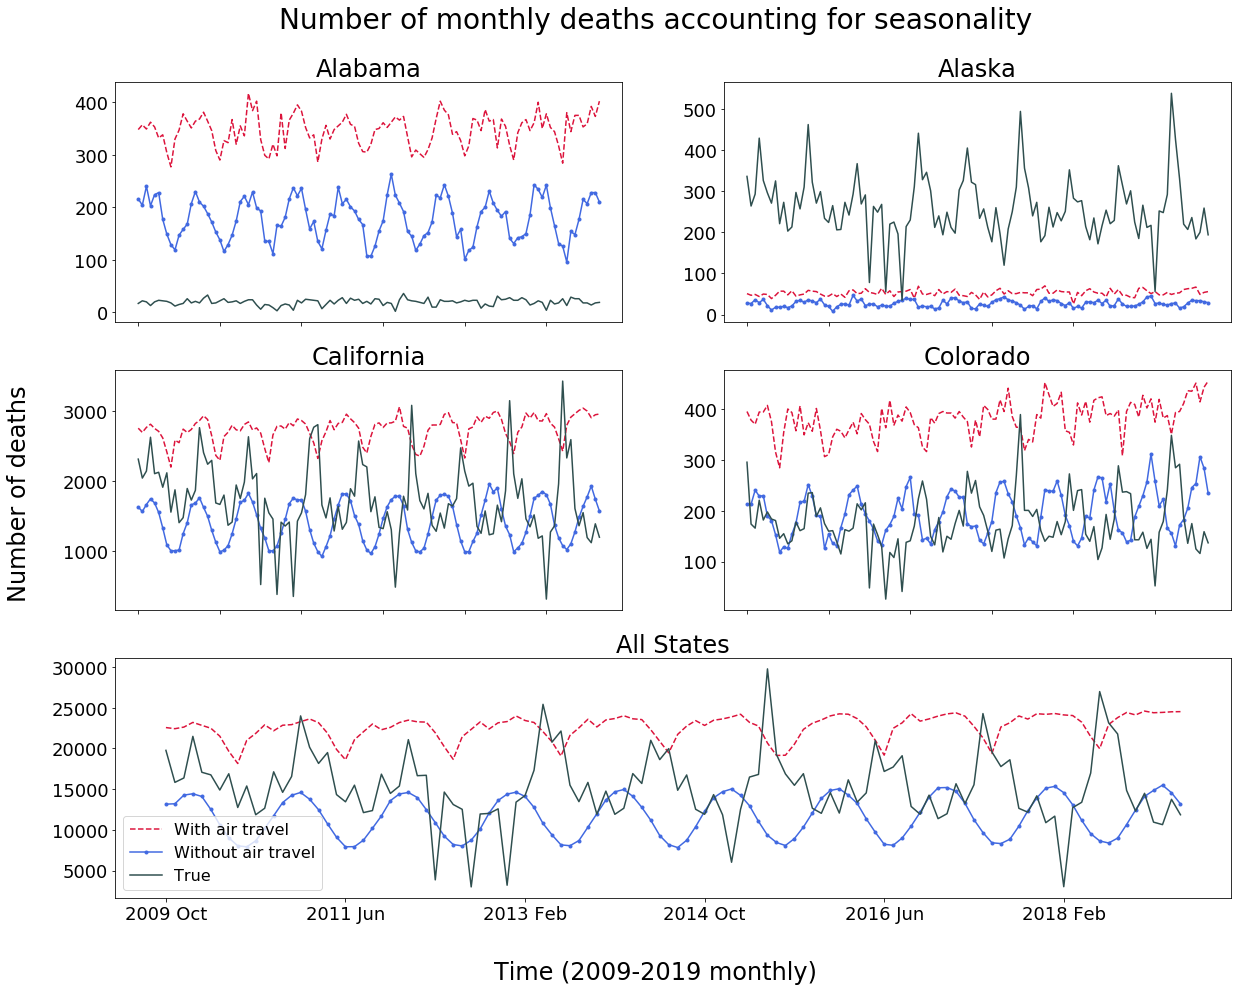

In [61]:
plt.rcParams['figure.figsize'] = [20, 15]

fig = plt.figure()

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=1,colspan=1,)
ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=1, colspan=1,)
ax3 = plt.subplot2grid((3, 2), (1, 0), rowspan=1, colspan=1,)
ax4 = plt.subplot2grid((3, 2), (1, 1), rowspan=1, colspan=1,)
# ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=1,)
ax6 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2,)

ax1.plot(range(114), sim_deaths_best[0], '--', color='crimson')
ax1.plot(range(114), sim_deaths_best_no_travel[0], '.-', color='royalblue')
ax1.plot(range(114), deaths_matrix[-1][:,:-5][0], color = 'darkslategrey')
ax1.set_title('Alabama', fontsize = 24)
ax1.set_xticklabels([])
ax1.tick_params(labelsize=18)

ax2.plot(range(114), sim_deaths_best[1], '--', color='crimson')
ax2.plot(range(114), sim_deaths_best_no_travel[1], '.-', color='royalblue')
ax2.plot(range(114), deaths_matrix[-1][:,:-5][1], color = 'darkslategrey')
ax2.set_title('Alaska', fontsize = 24)
ax2.set_xticklabels([])
ax2.tick_params(labelsize=18)

ax3.plot(range(114), sim_deaths_best[4], '--', color='crimson')
ax3.plot(range(114), sim_deaths_best_no_travel[4], '.-', color='royalblue')
ax3.plot(range(114), deaths_matrix[-1][:,:-5][4], color = 'darkslategrey')
ax3.set_title('California', fontsize = 24)
ax3.set_xticklabels([])
ax3.tick_params(labelsize=18)

ax4.plot(range(114), sim_deaths_best[5], '--', color='crimson')
ax4.plot(range(114), sim_deaths_best_no_travel[5], '.-', color='royalblue')
ax4.plot(range(114), deaths_matrix[-1][:,:-5][5], color = 'darkslategrey')
ax4.set_title('Colorado', fontsize = 24)
ax4.set_xticklabels([])
ax4.tick_params(labelsize=18)

# ax5.plot(range(38), sim_deaths_best[33])
# ax5.plot(range(38), deaths_matrix[-1][33])
# ax5.set_title('North Dakota', fontsize = 26)
# ax5.tick_params(labelsize=18)

# ax6.plot(range(114), sim_deaths_best[49], '--', color='crimson')
# ax6.plot(range(114), sim_deaths_best_no_travel[49], '.-', color='royalblue')
# ax6.plot(range(114), deaths_matrix[-1][:,:-5][49], color = 'darkslategrey')
# ax6.set_title('Wyoming', fontsize = 24)

ax6.plot(range(114), sim_deaths_best.sum(axis=0).tolist(), '--', color='crimson')
ax6.plot(range(114), sim_deaths_best_no_travel.sum(axis=0).tolist(), '.-', color='royalblue')
ax6.plot(range(114), deaths_matrix[-1][:,:-5].sum(axis=0).tolist(), color = 'darkslategrey')
ax6.set_title('All States', fontsize = 24)
ax6.tick_params(labelsize=18)
ax6.legend(['With air travel', 'Without air travel', 'True'], fontsize = 16)

tix = ax6.set_xticklabels([ '0', '2009 Oct', #'2009 Nov', '2009 Dec', '2010 Jan', '2010 Feb', '2010 Mar', '2010 Apr', '2010 May', '2010 Jun', '2010 Jul', '2010 Aug', '2010 Sep','2010 Oct', '2010 Nov', '2010 Dec', '2011 Jan', '2011 Feb', '2011 Mar', '2011 Apr', '2011 May',
                           '2011 Jun', #'2011 Jul', '2011 Aug', '2011 Sep', '2011 Oct', '2011 Nov', '2011 Dec', '2012 Jan', '2012 Feb', '2012 Mar', '2012 Apr', '2012 May', '2012 Jun', '2012 Jul', '2012 Aug', '2012 Sep', '2012 Oct', '2012 Nov', '2012 Dec', '2013 Jan',
                           '2013 Feb', #'2013 Mar', '2013 Apr', '2013 May', '2013 Jun', '2013 Jul', '2013 Aug', '2013 Sep', '2013 Oct', '2013 Nov', '2013 Dec', '2014 Jan', '2014 Feb', '2014 Mar', '2014 Apr', '2014 May', '2014 Jun', '2014 Jul', '2014 Aug', '2014 Sep',
                           '2014 Oct', #'2014 Nov', '2014 Dec', '2015 Jan', '2015 Feb', '2015 Mar', '2015 Apr', '2015 May', '2015 Jun', '2015 Jul', '2015 Aug', '2015 Sep', '2015 Oct', '2015 Nov', '2015 Dec', '2016 Jan', '2016 Feb', '2016 Mar', '2016 Apr', '2016 May',
                           '2016 Jun', #'2016 Jul', '2016 Aug', '2016 Sep', '2016 Oct', '2016 Nov', '2016 Dec', '2017 Jan', '2017 Feb', '2017 Mar', '2017 Apr', '2017 May', '2017 Jun', '2017 Jul', '2017 Aug', '2017 Sep', '2017 Oct', '2017 Nov', '2017 Dec', '2018 Jan',
                           '2018 Feb', #'2018 Mar', '2018 Apr', '2018 May', '2018 Jun', '2018 Jul', '2018 Aug', '2018 Sep','2018 Oct', '2018 Nov', '2018 Dec'
                          ]#, '2018 Q4', '2019 Q1']
                    )
fig.text(0.5, 0.93, 'Number of monthly deaths accounting for seasonality', ha='center', fontsize=28)
fig.text(0.05, 0.5, 'Number of deaths', va='center', rotation='vertical', fontsize=24)
fig.text(0.5, 0.05, 'Time (2009-2019 monthly)', ha='center', fontsize=24)
plt.savefig("../figures/states_monthly_with_seasonality.png", dpi=200, bbox_inches="tight")


# No seasonality

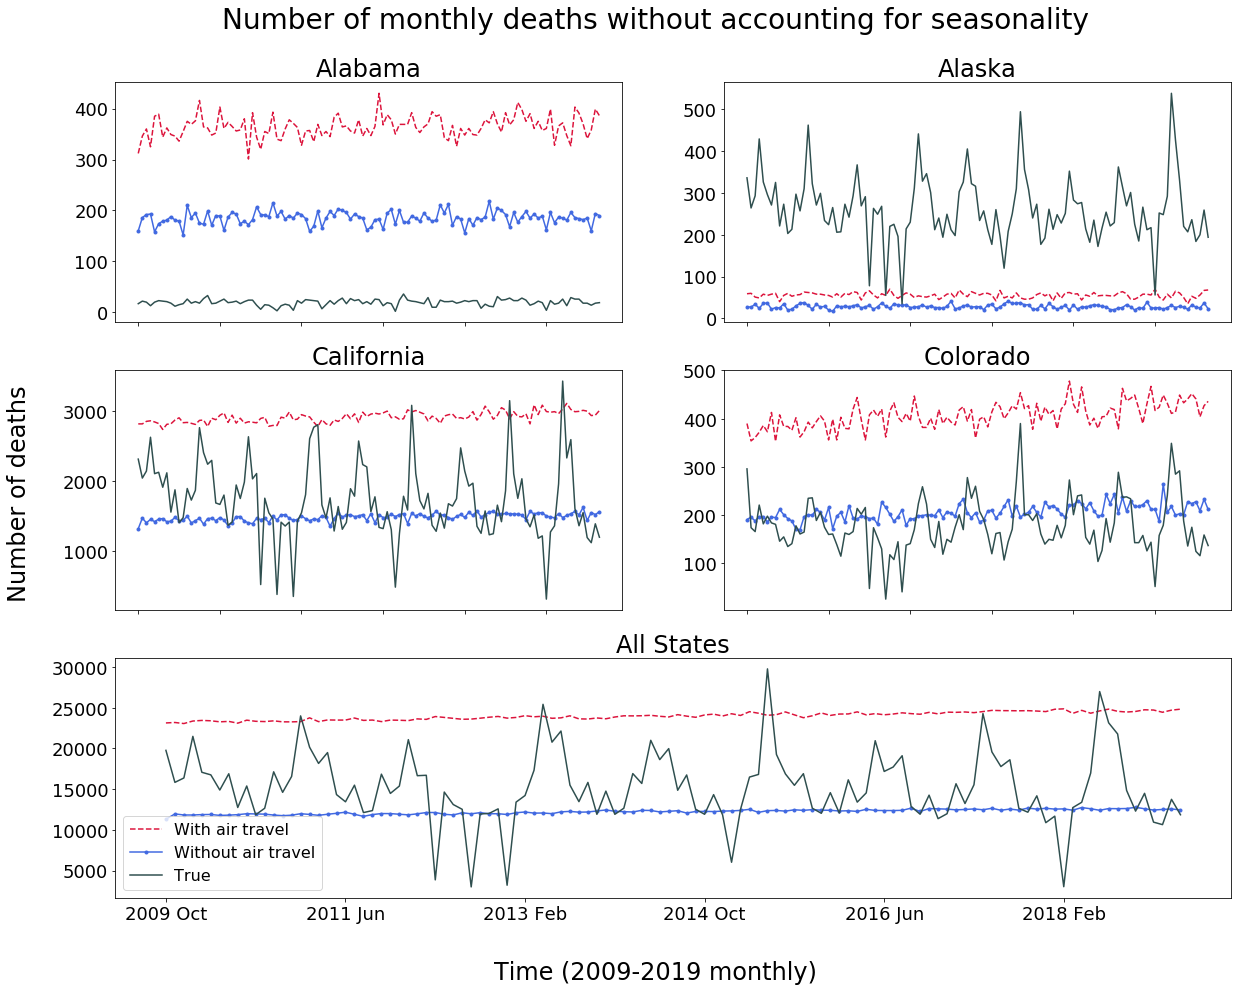

In [60]:
plt.rcParams['figure.figsize'] = [20, 15]

fig = plt.figure()

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=1,colspan=1,)
ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=1, colspan=1,)
ax3 = plt.subplot2grid((3, 2), (1, 0), rowspan=1, colspan=1,)
ax4 = plt.subplot2grid((3, 2), (1, 1), rowspan=1, colspan=1,)
# ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=1,)
ax6 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2,)

ax1.plot(range(114), sim_deaths_best_no_seasonality[0], '--', color='crimson')
ax1.plot(range(114), sim_deaths_best_neither[0], '.-', color='royalblue')
ax1.plot(range(114), deaths_matrix[-1][:,:-5][0], color = 'darkslategrey')
ax1.set_title('Alabama', fontsize = 24)
ax1.set_xticklabels([])
ax1.tick_params(labelsize=18)

ax2.plot(range(114), sim_deaths_best_no_seasonality[1], '--', color='crimson')
ax2.plot(range(114), sim_deaths_best_neither[1], '.-', color='royalblue')
ax2.plot(range(114), deaths_matrix[-1][:,:-5][1], color = 'darkslategrey')
ax2.set_title('Alaska', fontsize = 24)
ax2.set_xticklabels([])
ax2.tick_params(labelsize=18)

ax3.plot(range(114), sim_deaths_best_no_seasonality[4], '--', color='crimson')
ax3.plot(range(114), sim_deaths_best_neither[4], '.-', color='royalblue')
ax3.plot(range(114), deaths_matrix[-1][:,:-5][4], color = 'darkslategrey')
ax3.set_title('California', fontsize = 24)
ax3.set_xticklabels([])
ax3.tick_params(labelsize=18)

ax4.plot(range(114), sim_deaths_best_no_seasonality[5], '--', color='crimson')
ax4.plot(range(114), sim_deaths_best_neither[5], '.-', color='royalblue')
ax4.plot(range(114), deaths_matrix[-1][:,:-5][5], color = 'darkslategrey')
ax4.set_title('Colorado', fontsize = 24)
ax4.set_xticklabels([])
ax4.tick_params(labelsize=18)

# ax5.plot(range(38), sim_deaths_best[33])
# ax5.plot(range(38), deaths_matrix[-1][33])
# ax5.set_title('North Dakota', fontsize = 26)
# ax5.tick_params(labelsize=18)

# ax6.plot(range(114), sim_deaths_best_no_seasonality[49], '--', color='crimson')
# ax6.plot(range(114), sim_deaths_best_neither[49], '.-', color='royalblue')
# ax6.plot(range(114), deaths_matrix[-1][:,:-5][49], color = 'darkslategrey')
# ax6.set_title('Wyoming', fontsize = 24)

ax6.plot(range(114), sim_deaths_best_no_seasonality.sum(axis=0).tolist(), '--', color='crimson')
ax6.plot(range(114), sim_deaths_best_neither.sum(axis=0).tolist(), '.-', color='royalblue')
ax6.plot(range(114), deaths_matrix[-1][:,:-5].sum(axis=0).tolist(), color = 'darkslategrey')
ax6.set_title('All States', fontsize = 24)
ax6.tick_params(labelsize=18)
ax6.legend(['With air travel', 'Without air travel', 'True'], fontsize = 16)
tix = ax6.set_xticklabels([ '0', '2009 Oct', #'2009 Nov', '2009 Dec', '2010 Jan', '2010 Feb', '2010 Mar', '2010 Apr', '2010 May', '2010 Jun', '2010 Jul', '2010 Aug', '2010 Sep','2010 Oct', '2010 Nov', '2010 Dec', '2011 Jan', '2011 Feb', '2011 Mar', '2011 Apr', '2011 May',
                           '2011 Jun', #'2011 Jul', '2011 Aug', '2011 Sep', '2011 Oct', '2011 Nov', '2011 Dec', '2012 Jan', '2012 Feb', '2012 Mar', '2012 Apr', '2012 May', '2012 Jun', '2012 Jul', '2012 Aug', '2012 Sep', '2012 Oct', '2012 Nov', '2012 Dec', '2013 Jan',
                           '2013 Feb', #'2013 Mar', '2013 Apr', '2013 May', '2013 Jun', '2013 Jul', '2013 Aug', '2013 Sep', '2013 Oct', '2013 Nov', '2013 Dec', '2014 Jan', '2014 Feb', '2014 Mar', '2014 Apr', '2014 May', '2014 Jun', '2014 Jul', '2014 Aug', '2014 Sep',
                           '2014 Oct', #'2014 Nov', '2014 Dec', '2015 Jan', '2015 Feb', '2015 Mar', '2015 Apr', '2015 May', '2015 Jun', '2015 Jul', '2015 Aug', '2015 Sep', '2015 Oct', '2015 Nov', '2015 Dec', '2016 Jan', '2016 Feb', '2016 Mar', '2016 Apr', '2016 May',
                           '2016 Jun', #'2016 Jul', '2016 Aug', '2016 Sep', '2016 Oct', '2016 Nov', '2016 Dec', '2017 Jan', '2017 Feb', '2017 Mar', '2017 Apr', '2017 May', '2017 Jun', '2017 Jul', '2017 Aug', '2017 Sep', '2017 Oct', '2017 Nov', '2017 Dec', '2018 Jan',
                           '2018 Feb', #'2018 Mar', '2018 Apr', '2018 May', '2018 Jun', '2018 Jul', '2018 Aug', '2018 Sep','2018 Oct', '2018 Nov', '2018 Dec'
                          ]#, '2018 Q4', '2019 Q1']
                    )
fig.text(0.5, 0.93, 'Number of monthly deaths without accounting for seasonality', ha='center', fontsize=28)
fig.text(0.05, 0.5, 'Number of deaths', va='center', rotation='vertical', fontsize=24)
fig.text(0.5, 0.05, 'Time (2009-2019 monthly)', ha='center', fontsize=24)
plt.savefig("../figures/states_monthly_without_seasonality.png", dpi=200, bbox_inches="tight")


# Bar plot of number of deaths

Text(0.5, 1.0, 'Total number of deaths per quarter')

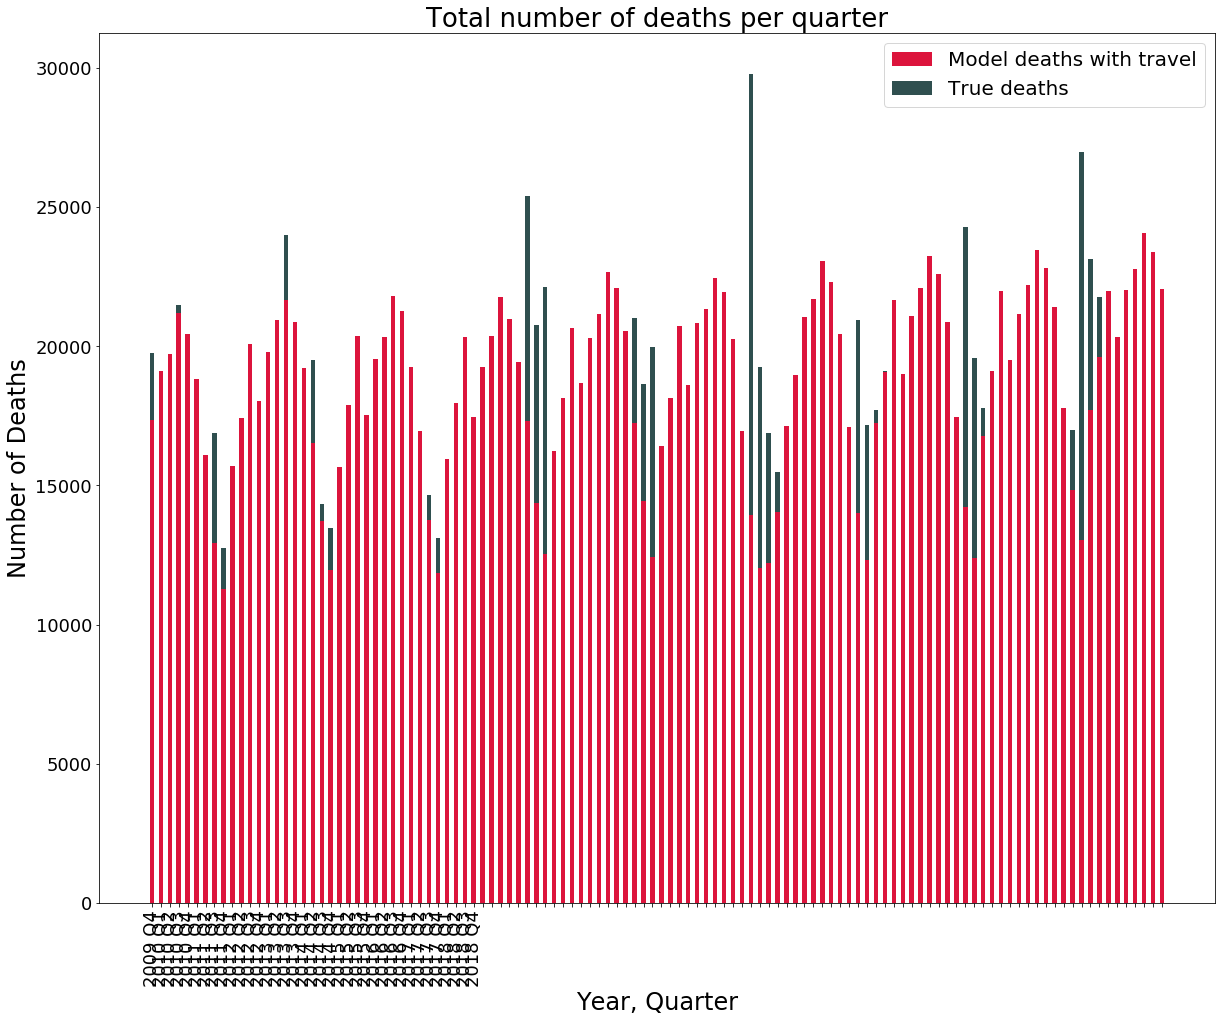

In [12]:
plt.figure(figsize=[20,16])
ind = np.arange(114)
width = 0.5

ax = plt.subplot(111)
p2 = ax.bar(ind, deaths_matrix[-1][:,:-5].sum(axis=0).tolist(), width, color = 'darkslategrey')
p1 = ax.bar(ind, sim_deaths_best.sum(axis=0).tolist(), width, color='crimson')
# p2 = ax.bar(ind, deaths_matrix[-1].sum(axis=0).tolist(), width,)

plt.xticks(ind, ('2009 Q4',
                '2010 Q1', '2010 Q2', '2010 Q3', '2010 Q4',
                '2011 Q1', '2011 Q2', '2011 Q3', '2011 Q4',
                '2012 Q1', '2012 Q2', '2012 Q3', '2012 Q4',
                '2013 Q1', '2013 Q2', '2013 Q3', '2013 Q4',
                '2014 Q1', '2014 Q2', '2014 Q3', '2014 Q4',
                '2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4',
                '2016 Q1', '2016 Q2', '2016 Q3', '2016 Q4',
                '2017 Q1', '2017 Q2', '2017 Q3', '2017 Q4',
                '2018 Q1', '2018 Q2', '2018 Q3', '2018 Q4'), rotation=90)
# ax.autoscale(tight=True)
# plt.yticks(np.arange(0, 81, 10))
# plt.xticks(rotation=70)
plt.legend((p1[0], p2[0]), ('Model deaths with travel', 'True deaths'), fontsize='20')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Year, Quarter", fontsize=24)
plt.ylabel("Number of Deaths", fontsize=24)
plt.title("Total number of deaths per quarter", fontsize=26)